In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn import tree
from IPython.display import Image
import pydotplus
import graphviz
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

import time


In [2]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8147 entries, 0 to 8593
Data columns (total 13 columns):
cntry      8147 non-null object
idno       8147 non-null float64
year       8147 non-null int64
tvtot      8147 non-null float64
ppltrst    8147 non-null float64
pplfair    8147 non-null float64
pplhlp     8147 non-null float64
happy      8147 non-null float64
sclmeet    8147 non-null float64
sclact     8147 non-null float64
gndr       8147 non-null float64
agea       8147 non-null float64
partner    8147 non-null float64
dtypes: float64(11), int64(1), object(1)
memory usage: 859.3+ KB


# Create Variables
Outcome variable is the happiness score.

In [3]:
y = df.happy
X = df.loc[:, ~df.columns.isin(['happy', 'cntry'])]
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

Here we manually imprement the boosting algorithm with decision trees.

Weak learner: 0 Rsquared: -21.86595826514709
Weak learner: 20 Rsquared: -0.0026192923008196978
Weak learner: 40 Rsquared: -0.0016748172727345523
Weak learner: 60 Rsquared: -0.0014818633549411597
Weak learner: 80 Rsquared: -0.0012578370480087475
Weak learner: 100 Rsquared: -0.0007136861925909344
0.5282873581794294


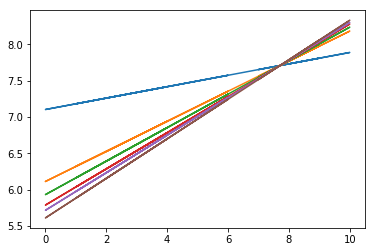

In [4]:
predictions = pd.DataFrame()
labels=[]
uniquex=df.happy.unique()

for m in range(0,101):
    decision_tree = tree.DecisionTreeRegressor(max_depth=2)
    decision_tree.fit(X,y)
    prediction =decision_tree.predict(X)
    predictions[m] = prediction
    
    y=y-prediction
    if m%20 == 0:
        print('Weak learner: {} Rsquared: {}'.format(m, decision_tree.score(X,y)))
        labels = labels+[m]
        bestprediction = predictions.sum(axis=1)
        plt.plot(uniquex, np.poly1d(np.polyfit(df['happy'], bestprediction, 1))(uniquex))

predicted = predictions.sum(axis=1)        
print(np.corrcoef(df['happy'], predicted)[0,1])

Now, I'll use the gradient boosting classifier built into sklearn to predict whether or not participants have a partner. I'll split the data into 10% testing and 90% training.

In [5]:
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner','cntry', 'idno'])]
X = pd.concat([X, pd.get_dummies(df.cntry)], axis=1)

offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

In [6]:
params = {'n_estimators':500, 'max_depth':2, 'loss':'deviance'}
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

table_test

col_0,0.0,1.0,All
partner,,,
0.0,454,51,505
1.0,151,159,310
All,605,210,815


Using random parameters gave us decent results but the accuracy could probably be increased by tuning the parameters. GridSearchCV comes in handy to choose the parameters that result in the best fit.

In [ ]:
start = time.time()
clf = ensemble.GradientBoostingClassifier()
parameters = {'n_estimators':[600, 700], 'max_depth':[6,7,8], 'loss':['deviance','exponential']}
grid = GridSearchCV(clf, parameters, cv=5, scoring='accuracy', n_jobs=-1)
print(grid.fit(X_train, y_train))
print(time.time()-start)

In [ ]:
grid.best_params_
#Seems deviance is the best loss function, and n_estimators > 600 has a worse effect. Lets redo it to get better parameters for
#max depth, the max_depth of 8 actually results in a worse score than a value of 2. Below we re-run the gridsearch to find better
#values.

In [ ]:
start = time.time()
clf = ensemble.GradientBoostingClassifier()
parameters = {'n_estimators':[600], 'max_depth':[2, 3, 4], 'loss':['deviance'], 'subsample':[1, .9, .8, .7]}
grid = GridSearchCV(clf, parameters, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_params_)
print(time.time()-start)

In [ ]:
#Plugging in the parameters obtained from the gridsearch
start = time.time()
params = {'n_estimators':600, 'max_depth':2, 'loss':'deviance', 'subsample':.93}
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))
print(clf.score(X_test, y_test))
print('time:', time.time()-start)

In [ ]:
start=time.time()
predy = clf.predict(X_test)
print(pd.crosstab(y_test,predy))
print(classification_report(y_test, predy))
print(time.time()-start)

# Conclusion

Using gridsearch for parameters, we got a subsample parameter of .7. However, this value actually resulted in more type 1 errors than the original model. After plugging in a few more values for subsample, we found that a subsample of .93 gave us the highest accuracy score when compared to the test sample. The model had an accuracy of around 75%, but was substantially worse at predicting people who lived with a partner. One possible explanation for this is the sampling size of people without partners is 3x greater than the sample of people with partners.